
Here we load data from the [CIC-Darknet2020](https://www.unb.ca/cic/datasets/darknet2020.html) dataset to explore methods of converting tabular data into image data using the Identity-oriented Tabular Image Transformation method.

In [1]:
import colorsys, contextlib, datetime, os, pathlib, platform, pprint, sys
import gtda
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import PIL.Image as Image
import plotly as py
import plotly.graph_objs as go
import plotly.io as pio
import pomegranate as pg
import seaborn as sns
import sdv
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import yellowbrick as yb

fastai_gpu_conflict = True
if(fastai_gpu_conflict):
    torch.cuda.is_available = lambda : False


from collections import namedtuple, ChainMap

import fastai
from fastai.basics import Tensor
from fastai.callback.all import CollectDataCallback, Callback, ProgressCallback
from fastai.callback.all import LRFinder, EarlyStoppingCallback, SaveModelCallback, ShowGraphCallback, CSVLogger, slide, steep, minimum, valley
from fastai.data.all import Transform, DisplayedTransform
from fastai.layers import Cat, Identity
from fastai.metrics import MatthewsCorrCoef, F1Score, Recall, Precision, RocAuc, BalancedAccuracy
from fastai.optimizer import ranger, Adam
from fastai.tabular.data import TabularDataLoaders, TabularPandas, MultiCategoryBlock
from fastai.tabular.all import delegates, tabular_config, TabularLearner, get_c, ifnone, is_listy, LinBnDrop, SigmoidRange 
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, range_of
from fastai.tabular.all import get_emb_sz, Module, Learner, Embedding, CrossEntropyLossFlat, IndexSplitter, ColSplitter, RandomSplitter
from fastai.test_utils import synth_learner, VerboseCallback
from fastai.torch_core import Enum

from fastcore.all import Transform, store_attr, L

from pytorch_tabnet.tab_network import TabNetNoEmbeddings
from fast_tabnet.core import TabNetModel as TabNet, tabnet_feature_importances, tabnet_explain

from gtda.curves import Derivative, StandardFeatures
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, PersistenceImage, BettiCurve, Silhouette, HeatKernel
from gtda.homology import VietorisRipsPersistence, EuclideanCechPersistence
from gtda.plotting import plot_diagram, plot_point_cloud, plot_betti_curves, plot_betti_surfaces

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots

from sdv.metrics.tabular import MulticlassDecisionTreeClassifier, CSTest, KSTest, ContinuousKLDivergence, BNLikelihood, GMLogLikelihood, LogisticDetection, MulticlassMLPClassifier, BNLogLikelihood
from sdv.tabular import TVAE, CopulaGAN, CTGAN, GaussianCopula
from sdv.evaluation import evaluate

from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from torch.utils.data import Dataset, DataLoader

from yellowbrick.model_selection import CVScores, LearningCurve, ValidationCurve

seed: int = 14

# allow plots to be shown in the notebook
init_notebook_mode(connected=True)
# pio.renderers.default = "iframe"



device = 'cuda' if torch.cuda.is_available() else 'cpu'

# set up pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint


# print library and python versions for reproducibility
print(
    f'''
    Last Execution: {datetime.datetime.now()}
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tgiotto-tda:\t{gtda.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tplotly:\t\t{py.__version__}
    \tseaborn:\t{sns.__version__}
    \tsdv:\t\t{sdv.__version__}
    \tsklearn:\t{sklearn.__version__}
    \ttorch:\t\t{torch.__version__}
    \tyellowbrick:\t{yb.__version__}

    \tdevice:\t\t{device}
    '''
)


    Last Execution: 2022-06-05 19:19:15.164811
    python:	3.7.10

    	fastai:		2.4.1
    	giotto-tda:	0.5.1
    	matplotlib:	3.5.1
    	numpy:		1.20.3
    	pandas:		1.3.4
    	plotly:		5.6.0
    	seaborn:	0.11.2
    	sdv:		0.13.1
    	sklearn:	1.0.2
    	torch:		1.9.0
    	yellowbrick:	1.3.post1

    	device:		cpu
    


First we create some helper functions to load and process the data

In [2]:
def get_file_path(directory: str) -> callable:
    '''
        Closure that will return a function. 
        Function will return the filepath to the directory given to the closure
    '''

    def func(file: str) -> str:
        return os.path.join(directory, file)

    return func



def load_data(filePath: str) -> pd.DataFrame:
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
    '''

    p = pathlib.Path(filePath)

    filePathClean: str = str(p.parts[-1])
    pickleDump   : str = f'./cache/{filePathClean}.pickle'

    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')


    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
 
    # if not, load data and clean it before caching it
    else:
        df: pd.DataFrame = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)
    
    return df



def features_with_bad_values(df: pd.DataFrame, datasetName: str) -> pd.DataFrame:
    '''
        Function will scan the dataframe for features with Inf, NaN, or Zero values.
        Returns a new dataframe describing the distribution of these values in the original dataframe
    '''

    # Inf and NaN values can take different forms so we screen for every one of them
    invalid_values: list = [ np.inf, np.nan, 'Infinity', 'inf', 'NaN', 'nan', 0 ]
    infs          : list = [ np.inf, 'Infinity', 'inf' ]
    NaNs          : list = [ np.nan, 'NaN', 'nan' ]

    # We will collect stats on the dataset, specifically how many instances of Infs, NaNs, and 0s are present.
    # using a dictionary that will be converted into a (3, n) dataframe where n is the number of features in the dataset
    stats: dict = {
        'Dataset':[ datasetName, datasetName, datasetName ],
        'Value'  :['Inf', 'NaN', 'Zero']
    }

    i = 0
    for col in df.columns:
        
        i += 1
        feature = np.zeros(3)
        
        for value in invalid_values:
            if value in infs:
                j = 0
            elif value in NaNs:
                j = 1
            else:
                j = 2
            indexNames = df[df[col] == value].index
            if not indexNames.empty:
                feature[j] += len(indexNames)
                
        stats[col] = feature

    return pd.DataFrame(stats)



def clean_data(df: pd.DataFrame, prune: list) -> pd.DataFrame:
    '''
        Function will take a dataframe and remove the columns that match a value in prune 
        Inf and Nan values will also be removed once appropriate rows and columns 
        have been removed, 
        we will return the dataframe with the appropriate values
    '''

    # remove the features in the prune list    
    for col in prune:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    
    # drop missing values/NaN etc.
    df.dropna(inplace=True)

    
    # Search through dataframe for any Infinite or NaN values in various forms that were not picked up previously
    invalid_values: list = [
        np.inf, np.nan, 'Infinity', 'inf', 'NaN', 'nan'
    ]
    
    for col in df.columns:
        for value in invalid_values:
            indexNames = df[df[col] == value].index
            if not indexNames.empty:
                print(f'deleting {len(indexNames)} rows with Infinity in column {col}')
                df.drop(indexNames, inplace=True)

    return df



def examine_dataset(job_id: int, files: str or None = None, datasets: str or None = None) -> ChainMap:
    '''
        Function will return a dictionary containing dataframe of the job_id passed in as well as that dataframe's
        feature stats, data composition, and file name.

        This dictionary is expected as the input for all of the other helper functions
    '''
    if files is None and 'file_set' in tuple(globals()):
        files = file_set

    if datasets is None and 'data_set' in tuple(globals()):
        datasets = data_set


    job_id = job_id - 1  # adjusts for indexing while enumerating jobs from 1
    print(f'Dataset {job_id+1}/{len(datasets)}: We now look at {files[job_id]}\n\n')

    # Load the dataset
    df: pd.DataFrame = load_data(files[job_id])
 

    # print the data composition
    print(f'''
        File:\t\t\t\t{files[job_id]}  
        Job Number:\t\t\t{job_id+1}
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats in a chainmap. This is a dictionary that can be
    #     updated by other functions, grouping together dictionaries and only showing the keys
    #     that appear first in the chainmap. This is useful for transforming the dataset and 
    #     performing experiments, so we can keep track of the history and do not need to reload
    #     the dataset.
    data_summary: ChainMap =  ChainMap({
        'File':             files[job_id],
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, files[job_id]), 
    })
    
    return data_summary



def package_data_for_inspection(df: pd.DataFrame) -> ChainMap:
    '''
        Function will return a dictionary containing dataframe passed in as well as that dataframe's feature stats.
    '''

    # print the data composition
    print(f'''
    Packaging Data:

    Dataset statistics:
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats
    data_summary: ChainMap =  ChainMap({
        'File':             '',
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, ''), 
    })
    
    return data_summary



def package_data_for_inspection_with_label(df: pd.DataFrame, label: str) -> ChainMap:
    '''
        Function will return a dictionary containing dataframe passed in as well as that dataframe's feature stats.
    '''

    # print the data composition
    print(f'''
    Packaging Data {label}:

    Dataset statistics:
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats
    data_summary: ChainMap =  ChainMap({
        'File':             f'{label}',
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, f'{label}'),
    })
    
    return data_summary



def rename_columns(data_summary: ChainMap, columns: list, new_names: list) -> ChainMap:
    '''
        Function will return the data_summary dict with the names of the columns in the dataframe changed
    '''

    df: pd.DataFrame = data_summary['Dataset'].copy()
    for x, i in enumerate(columns):
        df.rename(columns={i: new_names[x]}, inplace=True)

    out: dict = {'Dataset': df}

    return data_summary.new_child(out)



def rename_values_in_column(data_summary: ChainMap, replace: list) -> pd.DataFrame:
    '''
        Function will return a dataframe with the names of the columns changed

        replace: [('column', {'old_name': 'new_name', ...}), ...]
    '''
    length: int = len(replace)

    df: pd.DataFrame = data_summary['Dataset'].copy()
    for i in range(length):
        df[replace[i][0]].replace(replace[i][1], inplace=True)


    return df



def rename_values_in_column_df(df: pd.DataFrame, replace: list) -> pd.DataFrame:
    '''
        Function will return a dataframe with the names of the columns changed

        replace: [('column', {'old_name': 'new_name', ...}), ...]
    '''
    length: int = len(replace)

    df1: pd.DataFrame = df.copy()
    for i in range(length):
        df1[replace[i][0]].replace(replace[i][1], inplace=True)


    return df1



def prune_dataset(data_summary: ChainMap, prune: list) -> pd.DataFrame:
    '''
        Function will return the dataset with all the columns in the prune list removed.
    '''

    df: pd.DataFrame = data_summary['Dataset'].copy()
    df = clean_data(df, prune)

    return df



def prune_feature_by_values(df: pd.DataFrame, column: str, value: list) -> pd.DataFrame:
    '''
        Function takes a dataframe, a column name, and a list of values and returns a dataframe
        with all rows that do not have the values in the column removed

        Deprecated, use reduce_feature_to_values:
            ambiguous name implied it is removing values, not keeping them
    '''
    new_df = pd.DataFrame()
    for v in value:
        new_df = new_df.append(df[df[column] == v].copy())

    return new_df



def reduce_feature_to_values(df: pd.DataFrame, column: str, value: list) -> pd.DataFrame:
    '''
        Function takes a dataframe, a column name, and a list of values and returns a dataframe
        with all rows that do not have the values in the column removed
    '''
    new_df = pd.DataFrame()
    for v in value:
        new_df = new_df.append(df[df[column] == v].copy())

    return new_df



color_list: list = [
    'aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
    'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
    'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
    'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
    'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
    'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
    'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
    'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
    'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
    'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
    'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
    'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
    'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
    'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
    'ylorrd'
]


def get_n_color_list(n: int, opacity=.8, luminosity=.5, saturation=.5) -> list:
    '''
        Function creates a list of n distinct colors, formatted for use in a plotly graph
    '''

    colors = []

    for i in range(n):
        color = colorsys.hls_to_rgb(
                i / n,
                luminosity,
                saturation,
        )
        
        colors.append(f'rgba({color[0] * 255}, {color[1] * 255}, {color[2] * 255}, {opacity})')

    return colors


Now, we specify what datasets we want to load.

In [3]:
# This code is used to scale to processing numerous datasets, even though we currently are only looking at one now
data_path_1: str = './'   
data_set_1: list = [
    'Darknet_experiments_base.csv',
]

data_set: list   = data_set_1
file_path_1      = get_file_path(data_path_1)
file_set: list   = list(map(file_path_1, data_set_1))
current_job: int = 0


Classes and Wrappers

In [4]:
# Sklearn classes

class SklearnWrapper(BaseEstimator):
    '''
        A wrapper for fastai learners for creating visualizations using yellowbrick
        code sourced from: 
        forums.fast.ai/t/fastai-with-yellowbrics-how-to-get-roc-curves-more/79408
    '''
    _estimator_type = "classifier"
        
    def __init__(self, model):
        self.model = model
        self.classes_ = list(self.model.dls.y.unique())
        self._calls = [] 
    
    def fit(self, X, y):
        self._calls.append(('fit', X, y))
        pass
        
    def score(self, X, y):
        self._calls.append(('score', X, y))
        return accuracy_score(y, self.predict(X))
    
    def get_new_preds(self, X):
        self._calls.append(('get_new_preds', X))
        new_to = self.model.dls.valid_ds.new(X)
        new_to.conts = new_to.conts.astype(np.float32)
        new_dl = self.model.dls.valid.new(new_to)
        with self.model.no_bar():
            preds,_,dec_preds = self.model.get_preds(dl=new_dl, with_decoded=True)
        return (preds, dec_preds)

    def predict_proba(self, X):
        self._calls.append(('predict_proba', X))
        return self.get_new_preds(X)[0].numpy()
    
    def predict(self, X):
        self._calls.append(('predict', X))
        return self.get_new_preds(X)[1].numpy()


# fastai classes

# transforms for the dataloaders pipeline

class PCA_tabular(Transform):
    '''
        Class will implement a PCA feature extraction method for tabular data
        On setup, we train a pca on the training data, then extract n_comps from the entire dataset 
            the components are then added to the dataframe as new columns
    '''
    def __init__(self, n_comps=3, add_col=True):
        store_attr() # core function in the fastai library that stores all passed in parameters

    def setups(self, to, **kwargs):

        self.pca = PCA(n_components=self.n_comps)
        self.pca.fit(to.train.conts)
        pca = pd.DataFrame(self.pca.transform(to.conts))
        pca.columns = [f'pca_{i+1}' for i in range(self.n_comps)]

        for col in pca.columns:
            to.items[col] = pca[col].values.astype('float32')
        

        if self.add_col:
            for i in range(self.n_comps):
                if f'pca_{i+1}' not in to.cont_names: to.cont_names.append(f'pca_{i+1}')
        
        return self(to)



class Normal(DisplayedTransform):
    '''
        A data processing tool inherited from the fastai library. 
        This is a modified version of the normalize function that performs MinMax scaling and is able to be
            used in our preprocessing pipeline. 
        The original normalizes the data to have a mean centered at 0 and a standard deviation of 1.
    '''
    def setups(self, to, **kwargs):
        self.mins = getattr(to, 'train', to).conts.min()
        self.maxs = getattr(to, 'train', to).conts.max()
        
        return self(to)
        
    def encodes(self, to, **kwargs):
        to.conts = (to.conts-self.mins) / (self.maxs - self.mins)
        return to

    def decodes(self, to, **kwargs):
        to.conts = (to.conts) * (to.maxs - to.mins) + to.mins
        return to


# callbacks for the fastai training schedule

class DFLogger(Callback):
    '''
        Class defines a callback that is passed to the fastai learner that
            will save the recorded metrics for each epoch to a dataframe. 
            Also saves results from predictions with negative epochs
    '''
    order=60
    def __init__(self, fname='history.csv', append=False):
        self.fname,self.append = pathlib.Path(fname),append
        self.df = pd.DataFrame()
        self.np = np.array([])
        self.flag = True
        self.pred_count = 0

    def to_csv(self, file: str or None = None):
        if file is None:
            self.df.to_csv(self.path/self.fname, index=False)
        else:
            self.df.to_csv(file, index=False)

    def before_fit(self):
        "Prepare file with metric names."
        self.path.parent.mkdir(parents=True, exist_ok=True)
        self.old_logger,self.learn.logger = self.logger,self.add_row

    def add_row(self, log):
        "Write a line with `log` and call the old logger."
        if(self.flag):
            if not hasattr(self, "gather_preds"):
                self.df = pd.DataFrame([log], columns=self.recorder.metric_names)
            else:
                self.pred_count += 1
                print('predicting')
                self.df = pd.DataFrame([[-self.pred_count] + log], columns=self.recorder.metric_names)
            self.np = np.append(self.np, [log])
            self.flag = False
        else:
            if (len(log) == len(self.df.columns)):
                self.new_row = pd.DataFrame([log], columns=self.recorder.metric_names)
                self.df = pd.concat([self.df, self.new_row], ignore_index=True)
                self.np = np.append(self.np, log, axis=0)
            elif (len(log) < len(self.df.columns)):
                self.pred_count += 1
                self.new_row = pd.DataFrame([[-self.pred_count] + log], columns=self.recorder.metric_names)
                self.df = pd.concat([self.df, self.new_row], ignore_index=True)
                self.np = np.append(self.np, [-self.pred_count] + log, axis=0)

    def after_fit(self):
        "Close the file and clean up."
        self.learn.logger = self.old_logger



class LazyGraphCallback(Callback):
    '''
        Class defines a callback that is passed to the fastai learner that
            saves the validation and training loss metrics to graph when
            calling the .plot_graph() method
        
        This allows us to display the train/validation loss graph after the    
            experiment is run, even if it is run in no_bar mode
    '''
    order: int = 65
    run_valid: bool = False
    
    def __init__(self):
        self.graph_params: list = []
        self.graphs: list = []

    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds")
        if not self.run: return
        self.nb_batches: list = []

    def after_train(self): self.nb_batches.append(self.train_iter)

    def after_epoch(self):
        "Plot validation loss in the pbar graph"
        if not self.nb_batches: return
        rec = self.learn.recorder
        iters = range_of(rec.losses)
        val_losses = [v[1] for v in rec.values]
        x_bounds = (0, (self.n_epoch - len(self.nb_batches)) * self.nb_batches[0] + len(rec.losses))
        y_bounds = (0, max((max(Tensor(rec.losses)), max(Tensor(val_losses)))))
        self.graph_params.append(([(iters, rec.losses), (self.nb_batches, val_losses)], x_bounds, y_bounds))


    def plot_graph(self, ax: plt.Axes or None = None, title: str = 'Loss'):

        params = self.graph_params[-1]
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 4))
        ax.set_title(title)
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss')
        ax.plot(params[0][0][0], params[0][0][1], label='Training')
        ax.plot(params[0][1][0], params[0][1][1], label='Validation')
        ax.legend()



class ModelStatsCallback(Callback):
    '''
        Collect all batches, along with `pred` and `loss`, into `self.datum`.
        This allows the data to be used after the model is used.
    '''
    order=60 # mysterious param we need to investigate
    def __init__(self):
        self.datum: list = []
        self.records: list = []
        self.c_idx: int  = -1

    def before_fit(self):
        self.datum.append(L())
        self.records.append({'loss': [], 'predictions': []})
        self.c_idx += 1


    def after_batch(self):
        vals = self.learn.to_detach((self.xb,self.yb,self.pred,self.loss))
        self.datum[self.c_idx].append(vals)
        self.records[self.c_idx]['predictions'].append(vals[2])
        self.records[self.c_idx]['loss'].append(vals[3])
        self.records[self.c_idx]['iters'] = range_of(self.recorder.losses)


Different Learning Models

Functions to run classification experiments or to transform and split the data

In [5]:
Model_data = namedtuple(
    'model_data', 
    ['name', 'model', 'classes', 'X_train', 'y_train', 'X_test', 'y_test', 'to', 'dls', 'model_type']
)


def run_deep_nn_experiment(
    df: pd.DataFrame, 
    file_name: str, 
    target_label: str, 
    shape: tuple, 
    split=0.2, 
    categorical: list = ['Protocol'],
    procs = [FillMissing, Categorify, Normalize], 
    leave_out: list = [],
    epochs: int = 10,
    batch_size: int = 64,
    metrics: list or None = None,
    callbacks: list = [ShowGraphCallback],
    lr_choice: str = 'valley',
    name: str or None = None,
    fit_choice: str = 'one_cycle',
    no_bar: bool = False,
) -> Model_data:
    '''
        Function trains a deep neural network model on the given data. 

        Parameters:
            df: pandas dataframe containing the data
            file_name: name of the file the dataset came from
            target_label: the label to predict
            shape: the shape of the neural network, the i-th value in the tuple represents the number of nodes in the i+1 layer
                    and the number of entries in the tuple represent the number of layers
            name: name of the experiment, if none a default is given
            split: the percentage of the data to use for testing
            categorical: list of the categorical columns
            procs: list of preprocessing functions to apply in the dataloaders pipeline
                    additional options are: 
                        PCA_tabular (generate n principal components) 
                        Normal (features are scaled to the interval [0,1])
            leave_out: list of columns to leave out of the experiment
            epochs: number of epochs to train for
            batch_size: number of samples processed in one forward and backward pass of the model
            metrics: list of metrics to calculate and display during training
            callbacks: list of callbacks to apply during training
            lr_choice: where the learning rate sampling function should find the optimal learning rate
                        choices are: 'valley', 'steep', 'slide', and 'minimum'
            fit_choice: choice of function that controls the learning schedule choices are:
                                'fit': a standard learning schedule 
                                'flat_cos': a learning schedule that starts high before annealing to a low value
                                'one_cyle': a learning schedule that warms up for the first epochs, continues at a high
                                                learning rate, and then cools down for the last epochs
                                the default is 'one_cycle'
         
        
        returns a model data named tuple
            model_data: tuple = (file_name, model, classes, X_train, y_train, X_test, y_test, model_type)
    '''
    shape = tuple(shape)

    if name is None:
        width: int = shape[0]
        for x in shape:
            width = x if (x > width) else width
        name = f'Deep_NN_{len(shape)}x{width}'

    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [accuracy, BalancedAccuracy(), RocAuc(), MatthewsCorrCoef(), F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    

    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    # extract the file_name from the path
    p = pathlib.Path(file_name)
    file_name: str = str(p.parts[-1])


    learner = tabular_learner(
        dls, 
        layers=list(shape), 
        metrics = metrics,
        cbs=callbacks,
    )

    with learner.no_bar() if no_bar else contextlib.ExitStack() as gs:

        lr = learner.lr_find(suggest_funcs=[valley, slide, steep, minimum])

            # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
        if(fit_choice == 'fit'):
            learner.fit(epochs, lr[lr_choice])
        elif(fit_choice == 'flat_cos'):
            learner.fit_flat_cos(epochs, lr[lr_choice])
        elif(fit_choice == 'one_cycle'):
            learner.fit_one_cycle(epochs, lr_max=lr[lr_choice])
        else:
            assert False, f'{fit_choice} is not a valid fit_choice'

        learner.recorder.plot_sched() 
        results = learner.validate()
        interp = ClassificationInterpretation.from_learner(learner)
        interp.plot_confusion_matrix()
                

    print(f'loss: {results[0]}, accuracy: {results[1]*100: .2f}%')
    learner.save(f'{file_name}.model')

    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = SklearnWrapper(learner)

    classes = list(learner.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    model_data: Model_data = Model_data(file_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, name)


    return model_data


def run_knn_experiment(df: pd.DataFrame, name: str, target_label: str, split=0.2, categorical : list = ['Protocol'], leave_out: list = [], model = None) -> Model_data:
    '''
        Run binary classification using K-Nearest Neighbors
        returns the 10-tuple Model_data
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = target_label
    print(df.shape)

 
    categorical_features: list = []
    untouched_features  : list = []


    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))


    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )


    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    temp_model = tabular_learner(dls)
    classes : list = list(temp_model.dls.vocab)


    # extract the name from the path
    p = pathlib.Path(name)
    name: str = str(p.parts[-1])


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


    # Now that we have the train and test datasets, we set up a gridsearch of the K-NN classifier
    # using SciKitLearn and print the results 
    # params = {"n_neighbors": range(1, 50)}
    # model = GridSearchCV(KNeighborsClassifier(), params)
    
    if( model == None ):
        model = KNeighborsClassifier()

    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    report = classification_report(y_test, prediction)
    print(report)
    print(f'\tAccuracy: {accuracy_score(y_test, prediction)}\n')

    # print("Best Parameters found by gridsearch:")
    # print(model.best_params_)


   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')

    model_data: Model_data = Model_data(name, model, classes, X_train, y_train, X_test, y_test, to, dls, f'K_Nearest_Neighbors')

    # Now that the classifier has been created and trained, we pass out our training values
    # for analysis and further experimentation
    return model_data




def transform_and_split_data(df: pd.DataFrame, target_label: str, split=0, name='', categorical : list = ['Protocol'], scale:bool = False, leave_out: list = []) -> Model_data:
    '''
        Transform and split the data into a train and test set
        returns the 10-tuple with the following indicies:
        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var             : str  = target_label
    categorical_features: list = []
    untouched_features  : list = []

    print(df.shape)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))


    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    if(scale): 
        procs.append(Normal)

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )


    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    model = tabular_learner(dls)
    classes : list = list(model.dls.vocab)


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        model.target_type_ = 'single'
        
    model_data: Model_data = Model_data(name, model, classes, X_train, y_train, X_test, y_test, to, dls, 'Transformed_and_Split_data')

    # Now that the classifier has been created and trained, we pass out our training values
    # for analysis and further experimentation
    return model_data

Cross-Validated Experiment Functions

Dataset Preparation Tools


In [6]:
def decode_classes_and_create_Xy_df(model_data: Model_data, target_label: str):
    """
        Function takes a Model_data namedtuple and returns a dataframe with the X and decoded y data
    """
    X = model_data.X_train
    y = model_data.y_train
    classes = model_data.classes

    Xy_df = pd.DataFrame(X)
    y_s: list = []
    for x in y:
        y_s.append(classes[x])
    Xy_df[target_label] = y_s

    return Xy_df


def normalize_bilabel_dataset_between_0_1(df: pd.DataFrame, labels = ['Traffic Type', 'Application Type']) -> pd.DataFrame:
    '''
        Function takes a dataframe and merges its labels before normalizing data. 
        The labels are then split back into their original form, but the merged label is kept for verification purposes.

        returns a trilabel dataframe with the new label under the 'Merged Type' column
    '''
    inter_df = df.copy()

    d1_y = inter_df[labels[0]]
    d2_y = inter_df[labels[1]]

    merged_y = pd.concat([d1_y, d2_y], axis=1)

    merged: list = []
    for x in zip(d1_y, d2_y):
        merged.append(f'{x[0]}_{x[1]}')

    inter_df['Merged Type'] = merged

    normalized_model_data = transform_and_split_data(
        inter_df,
        'Merged Type',
        split=0,
        scale=True,
        categorical=[],
        leave_out=labels
    )

    merged_df = decode_classes_and_create_Xy_df(normalized_model_data, 'Merged Type')

    merged_y = merged_df['Merged Type']
    new_labels: list = []

    for l in labels:
        new_labels.append([])

    for x in merged_y:
        split_label = x.split('_')

        for i in range(len(split_label)):
            new_labels[i].append(split_label[i])

    for i, x in enumerate(labels):
        merged_df[x] = new_labels[i]

    total_df = merged_df.copy()
    total_df['Merged Type'] = merged_y


    return total_df

    

def create_n_cloud_from_dataset(df: pd.DataFrame, n_points: int = 100, target_label: str = 'label', allow_partial: bool = False, segmented=True):
    '''
        Function takes a dataframe and splits it into point clouds with n_points each. 
            The generated clouds will all have the indicated number of points, discarding the remainder if allow_partial is False.
            The generated clouds will be partitioned by the classes contained within the target_label column.
            Each cloud will be labeled with the class it was generated from.

            If the segmented parameter is true, the clouds will be split into df.shape[0]/n_points number of clouds.
                This is because we segment the dataframe to produce the clouds.
            if the segmented parameter is false, the clouds will be split into df.shape[0] - n_points number of clouds.
                This is because we will be using a sliding interval to construct the clouds.

        returns a numpy array of point clouds as well as a numpy array with class labels and class mappings.
    '''

    data = transform_and_split_data(df, target_label=target_label, split=0)
    X = data.X_train.copy()
    X[target_label] = data.y_train.copy()

    classes = data.classes

    # create n clouds by class
    clouds          : list = []
    clouds_y        : list = []
    clouds_y_decoded: list = []

    for i, x in enumerate(classes):
        temp_df = X[X[target_label] == i]
        if(segmented):
            iterations: int = int(temp_df.shape[0]/n_points)
        else:
            iterations: int = temp_df.shape[0] - n_points


        for j in range(int(iterations)):
            if(segmented):
                cloud = temp_df[j*n_points:(j+1)*n_points].drop(target_label, axis=1).values
            else:
                cloud = temp_df[j:j+n_points].drop(target_label, axis=1).values
            
            keep: bool = allow_partial and not segmented
            if(len(cloud) == n_points or keep):
                clouds.append(cloud)
                clouds_y.append(i)
                clouds_y_decoded.append(x)

    clouds = np.array(clouds)
    clouds_y = np.array(clouds_y)
    clouds_y_decoded = np.array(clouds_y_decoded)

    return clouds, clouds_y, classes, clouds_y_decoded



##### Clustering Functions

Clustering using Linear Feature Reduction through Principal Component Analysis

In [7]:
PCA_data = namedtuple(
    'pca_data',
    ['title', 'X_train', 'y_train', 'Xy', 'components', 'n_components', 'classes', 'target_label']
)



def show_clusters_by_label_1D_pca(model_data: tuple, samples=25000, title='Clusters by Label') -> None:
    '''
        Takes the 10-tuple model_data from the transform and split function and uses Principal component analysis
            to break up the feature dimensions into a single dimension for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    pca               = PCA(n_components=1)
    component         = pd.DataFrame(pca.fit_transform(X.drop(['label'], axis=1)))
    component.columns = ["component_1"]

    _X              = pd.concat([X, component], axis=1, join='inner')
    new_X           = pd.DataFrame(np.array(_X.sample(samples)))
    new_X.columns   = _X.columns
    new_X["filler"] = 0


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter(
                x=cluster["component_1"],
                y=cluster["filler"],
                mode='markers',
                marker = dict(color = label_colors[i]),
                name=classes[i],
            )
        )

    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5,zeroline= False
        ),
        yaxis= dict(
            title= '',
            ticklen= 5,
            zeroline= False
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_2D_pca(model_data: tuple, samples=25000, title='Clusters by Label') -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses Principal component analysis
            to break up the feature dimensions into two dimension  for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    pca               = PCA(n_components=2)
    component         = pd.DataFrame(pca.fit_transform(X.drop(['label'], axis=1)))
    component.columns = ["component_1", "component_2"]


    _X            = pd.concat([X, component], axis=1, join='inner')
    new_X         = pd.DataFrame(np.array(_X.sample(samples)))
    new_X.columns = _X.columns


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 2',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_3D_pca(model_data: tuple, samples=25000, title='Clusters by Label') -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses Principal component analysis
            to break up the feature dimensions into three dimensions for cluster analysis.
            Displays a graph of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    pca               = PCA(n_components=3)
    component         = pd.DataFrame(pca.fit_transform(X.drop(['label'], axis=1)))
    component.columns = ["component_1", "component_2", "component_3"]


    _X            = pd.concat([X, component], axis=1, join='inner')
    new_X         = pd.DataFrame(np.array(_X.sample(samples)))
    new_X.columns = _X.columns


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces.append(
            go.Scatter3d(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                z      = cluster["component_3"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 2',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )


    iplot({'data': traces, 'layout': layout})



def show_clusters_by_label_4D_pca(model_data: tuple, samples=25000, title='Clusters by Label') -> None:
    '''
        Takes a 10-tuple from the run_experiments function and uses Principal component analysis
            to break up the feature dimensions into four dimensions for cluster analysis.
            Displays a 2 two-dimensional graphs of the clusters colored by label

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    X            = model_data.X_train.copy()
    X['label']   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby('label').size())
    label_colors = get_n_color_list(num_labels, opacity=.4)


    pca               = PCA(n_components=4)
    component         = pd.DataFrame(pca.fit_transform(X.drop(['label'], axis=1)))
    component.columns = ["component_1", "component_2", "component_3", "component_4"]


    _X            = pd.concat([X, component], axis=1, join='inner')
    new_X         = pd.DataFrame(np.array(_X.sample(samples)))
    new_X.columns = _X.columns


    traces1: list = []
    traces2: list = []
    for i in range(num_labels):
        cluster = new_X[new_X['label'] == i]
        traces1.append(
            go.Scatter(
                x      = cluster["component_1"]    ,
                y      = cluster["component_2"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )
        traces2.append(
            go.Scatter(
                x      = cluster["component_3"]    ,
                y      = cluster["component_4"]    ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout1 = dict(
        title = title,
        xaxis= dict(
            title= 'Component 1',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 2',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )

    layout2 = dict(
        title = title,
        xaxis= dict(
            title= 'Component 3',
            ticklen= 5          ,
            zeroline= False     ,
        ),
        yaxis= dict(
            title= 'Component 4',
            ticklen= 5          ,
            zeroline= False     ,
        )
    )


    iplot({'data': traces1, 'layout': layout1})
    iplot({'data': traces2, 'layout': layout2})


def pca_to_model_data(pca_data: PCA_data) -> Model_data:
    '''
        Takes a PCA_data namedtuple and returns a model_data namedtuple
    '''

    model_data: Model_data = Model_data(
        pca_data.title,
        None,
        pca_data.classes,
        pca_data.X_train,
        pca_data.y_train,
        None,
        None,
        None,
        None,
        'pca'
    )

    return model_data


def run_pca_on_dataset(model_data: tuple, target_label: str = 'label',  title='PCA data', components: int = 6) -> PCA_data:


    X            = model_data.X_train.copy()
    classes      = model_data.classes
    # num_labels   = len(X.groupby(target_label).size())


    pca               = PCA(n_components=components)
    component         = pd.DataFrame(pca.fit_transform(X))
    component.columns = ['PCA_' + str(i+1) for i in range(components)]

    for col in component.columns:
        X[col] = component[col]


    Xy = decode_classes_and_create_Xy_df(Model_data(None, None, classes, component.copy(), model_data.y_train, None, None, None, None, 'pca'), target_label)
    component[target_label] = model_data.y_train

    pca_data: PCA_data = PCA_data(title, X, model_data.y_train, Xy, component, components, classes, target_label)



    return pca_data


Clustering using tools built using Topological Data Analysis

In [8]:
Topology_data = namedtuple(
    'topology_data',
    ['title', 'clouds', 'clouds_y', 'persistence', 'fig', 'features', 'classes', 'target_label', 'clouds_y_decoded', 'Xy']
)



def calculate_single_batch_dataset_topology(model_data: tuple, samples: int or None = 1000, dimensions: tuple = (0,1), title=''):
    """
    Function calculates the topology of the dataset and returns it
        requires data to be transformed by fastai first to properly encode and normalize the
        data.

    Returns a namedtuple with the following fields:
        title: Graph title
        persistence: Vietoris-Rips Peristence
        fig: plotly figure
        features: Persistence Entropy

    """

    if(model_data.name != '' and title == ''):
        title = model_data.name


    if(samples is None):
        X = model_data.X_train.values
    else:
        X = model_data.X_train.sample(samples).values
        
    X = np.array([X])

    # calculate the topology
    VR = VietorisRipsPersistence(homology_dimensions=dimensions)
    topology = VR.fit_transform(X)

    # calculate the persistence diagram
    fig = plot_diagram(topology[0])

    # calculate the entropy
    PE = PersistenceEntropy()
    entropy = PE.fit_transform(topology)

    # package in topological_data named tuple. We do this so data can be accessed using [i] or . operators
    topological_data: Topology_data = Topology_data(title, X, None, topology, fig, entropy, model_data.classes, '', None, None)

    return topological_data


def run_tda_on_dataset(df: pd.DataFrame, target_label: str = 'label',  title='Clusters by Label', n_points: int = 100, dimension: tuple = (0,1), allow_partial: bool = False, segmented: bool = True, jobs: int = None) -> Topology_data:
    '''
        Function takes a dataset and breaks it into n_point clouds, where n_point is the number of points in each cloud.
            Then, the giotto-tda Topological Data Analysis toolkit is used to generate a 
            persistence module for each cloud. This module describes the topological structure of the cloud.
            The topological diagrams have their entropy calculated to break up the feature dimensions into
            the indicated dimensions corresponding to topological features like connectivity(0d), loopiness(1d), caviatation(2d), etc
            for cluster analysis.
            Allow_partial is a boolean that determines whether or not to allow clouds to be less 
            than n_points if there arent n_points remaining.

        Returns the topological data for the dataset

        Topology_data = namedtuple(
           'topology_data',
            ['title', 'clouds', 'clouds_y', 'persistence', 'fig', 'features', 'classes', 'target_label', 'clouds_y_decoded']
        )
    '''


    clouds, clouds_y, classes, clouds_y_decoded = create_n_cloud_from_dataset(df, n_points=n_points, target_label=target_label, allow_partial=allow_partial, segmented=segmented)

    VR = VietorisRipsPersistence(homology_dimensions=dimension, n_jobs=jobs)
    PE = PersistenceEntropy()

    topologies = VR.fit_transform(clouds)

    entropies = pd.DataFrame(PE.fit_transform(topologies))

    col: list = []
    for n in dimension:
        col.append(f'{n}d entropy')
    entropies.columns = col

    Xy = entropies.copy()
    Xy[target_label] = clouds_y_decoded


    entropies[target_label] = clouds_y

    topology_data: Topology_data = Topology_data(title, clouds, clouds_y, topologies, None, entropies, classes, target_label, clouds_y_decoded, Xy)

    return topology_data


def show_clusters_by_label_2D_tda(df: pd.DataFrame, target_label: str = 'label',  title='Clusters by Label', n_points: int = 100, allow_partial: bool = False) -> Topology_data:
    '''
        Function takes a dataset and breaks it into n_point clouds, where n_point is the number of points in each cloud.
            Then, the giotto-tda Topological Data Analysis toolkit is used to generate a 
            persistence module for each cloud. This module describes the topological structure of the cloud.
            The topological diagrams have their entropy calculated to break up the feature dimensions into
            two dimensions corresponding to connectivity and loopinessfor cluster analysis.
            Allow_partial is a boolean that determines whether or not to allow clouds to be less 
            than n_points if there arent n_points remaining.
            Displays a graph of the clusters colored by label

        Returns the topological data for the dataset
    '''


    clouds, clouds_y, classes, clouds_y_decoded = create_n_cloud_from_dataset(df, n_points=n_points, target_label=target_label, allow_partial=allow_partial)

    VR = VietorisRipsPersistence(homology_dimensions=(0,1))
    PE = PersistenceEntropy()

    topologies      = VR.fit_transform(clouds)

    X               = pd.DataFrame(PE.fit_transform(topologies))
    X.columns       = ["Connectivity", "Loopiness"]
    X[target_label] = clouds_y
    num_labels      = len(X.groupby(target_label).size())
    label_colors    = get_n_color_list(num_labels, opacity=.4)


    traces: list = []
    for i in range(num_labels):
        cluster = X[X[target_label] == i]
        traces.append(
            go.Scatter(
                x      = cluster["Connectivity"]   ,
                y      = cluster["Loopiness"]      ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis= dict(
            title= 'Connectivity',
            ticklen= 5           ,
            zeroline= False      ,
        ),
        yaxis= dict(
            title= 'Loopiness',
            ticklen= 5        ,
            zeroline= False   ,
        )
    )

    fig = {'data': traces, 'layout': layout}

    iplot(fig)

    topology_data: Topology_data = Topology_data(title, clouds, clouds_y, topologies, fig, X, classes, target_label, clouds_y_decoded, None)

    return topology_data


def extract_topological_correlations(topology_data: Topology_data, original_dataset: pd.DataFrame, label: str):
    '''
        Takes a Topology_data namedtuple and returns a dictionary of lists of features ordered topological correlations 
            for each value in the topology_data.entropy dataframe with the values of the points in the point clouds
            being used to calculate the persistence entropy
    '''        

    cols = list(original_dataset.columns)
    if(label in cols):
        cols.remove(label)

    df = pd.DataFrame()
    new_cols = list(topology_data.features.columns)
    for i, x in enumerate(topology_data.clouds):
        new_df = pd.DataFrame(x)
        for col in new_cols:
            new_df[col] = topology_data.features[col][i]
        df = pd.concat([df, new_df], ignore_index=True)

    df.columns = cols + new_cols

    correlation = df.corr()

    correlations: dict = {}
    for col in new_cols:
        if col != label:
            correlations[col] = extract_correlations(correlation, col)

    for cor in correlations.keys():
        for col in new_cols:
            if col in correlations[cor]:
                correlations[cor].remove(col)


    correlations['Graph'] = plt.figure(figsize=(20,15))
    sns.heatmap(correlation, vmax=1, square=True, cmap='YlGnBu')
    plt.title("Topographic Correlation Heatmap for n_clouds Generated by Traffic Type", fontsize=16)

    return correlations



def top_to_model_data(topology_data: Topology_data) -> Model_data:
    '''
        Takes a Topology_data namedtuple and returns a model_data namedtuple
    '''

    X_train = topology_data.features.copy()

    if topology_data.target_label in X_train.columns:
        X_train.drop(topology_data.target_label, axis=1, inplace=True)

    model_data: Model_data = Model_data(
        topology_data.title,
        None,
        topology_data.classes,
        X_train,   
        topology_data.clouds_y,
        None,
        None,
        None,
        None,
        'topology'
    )

    return model_data

Tools to visualize the results of classification experiments

In [9]:
def visualize_confusion_matrix(model_data: tuple, ax=None, cmap='Blues') -> yb.classifier:
    '''
        Takes a 10-tuple from the run_experiments function and creates a confusion matrix

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.classifier.ConfusionMatrix(model_data[1], classes=model_data[2], title=model_data[0], ax=ax, cmap=cmap, is_fitted=True)
    visualizer.score(model_data[5], model_data[6])
    
    return visualizer


def visualize_roc(model_data: tuple, ax=None, cmap='Blues') -> yb.classifier:
    '''
        Takes a 10-tuple from the run_experiments function and creates a 
        Receiver Operating Characteristic (ROC) Curve

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.classifier.ROCAUC(model_data[1], classes=model_data[2], title=model_data[0], ax=ax, cmap=cmap)
    visualizer.score(model_data[5], model_data[6])
    
    return visualizer



def visualize_pr_curve(model_data: tuple, ax=None, cmap='Blues') -> yb.classifier:
    '''
        Takes a 10-tuple from the run_experiments function and creates a 
        Precision-Recall Curve

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.classifier.PrecisionRecallCurve(model_data[1], title=model_data[0], ax=ax, cmap=cmap)
    visualizer.score(model_data[5], model_data[6])

    return visualizer



def visualize_report(model_data: tuple, ax=None, cmap='Blues') -> yb.classifier:
    '''
        Takes a 10-tuple from the run_experiments function and creates a report
        detailing the Precision, Recall, f1, and Support scores for all 
        classification outcomes

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.classifier.ClassificationReport(model_data[1], classes=model_data[2], title=model_data[0], support=True, ax=ax, cmap=cmap)
    visualizer.score(model_data[5], model_data[6])

    return visualizer



def visualize_class_balance(model_data: tuple, ax=None, cmap='Blues') -> yb.classifier:
    '''
        Takes a 10-tuple from the run_experiments function and creates a histogram
        detailing the balance between classification outcomes

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    visualizer = yb.target.ClassBalance(labels=model_data[0], ax=ax, cmap=cmap)
    visualizer.fit(model_data[4], model_data[6])
    
    return visualizer



def confusion_matrix_from_dataset(model_data: tuple, df: pd.DataFrame, ax=None, cmap='Blues') -> yb.classifier:
    '''
        Takes a 10-tuple from the run_experiments function and uses the model to classify
            the data passed in as the dataframe. Produces a confusion matrix
            (currently only confirmed to work with fastai models)

        model_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    dl = model_data[1].model.dls.test_dl(df, bs=64)
    preds, v, dec_preds = model_data[1].model.get_preds(dl=dl, with_decoded=True)

    visualizer = yb.classifier.ConfusionMatrix(model_data[1], classes=model_data[2], title=model_data[0], ax=ax, cmap=cmap)
    visualizer.score(dl.xs, dl.y)
    acc = accuracy_score(dl.y, dec_preds)
    print(f'Accuracy: {acc}')

    return visualizer


def show_stacked_graphs(figures: list, stack_shape: tuple = (1,1), title: str = '', individual_titles: list or str = None) -> widgets.VBox: 
    """
    Function takes a list of figures and stacks them in a grid.
        stack_shape is a tuple of the number of rows and columns in the grid and
        the product of the indices must equal the number of figures.
        individual_titles allows one to specify titles for each figure, or a single title for all figures.

    Returns a plotly figure with the input figures stacked as indicated
    """

    if(individual_titles is not None and type(individual_titles) is not str):
        assert len(figures) == len(individual_titles)     , "Number of titles must match number of figures"
    assert len(figures) == stack_shape[0] * stack_shape[1], "Number of figures must match stack shape"

    vertical_stack  : list = []
    horizantal_stack: list = []

    if(title != ''):
        vertical_stack.append(widgets.Label(title))
    
    for i in range(stack_shape[1]):
        for j in range(stack_shape[0]):
                
            temp_fig = go.FigureWidget(figures[i * stack_shape[0] + j].data)
            if(type(individual_titles) == str):
                temp_fig.layout.title = individual_titles
            elif(type(individual_titles) == list):
                temp_fig.layout.title = individual_titles[i * stack_shape[0] + j]
                
            horizantal_stack.append(temp_fig)
        vertical_stack.append(widgets.HBox(horizantal_stack))
        horizantal_stack = []

    fig = widgets.VBox(vertical_stack)

    return fig


def show_clusters_by_label_2D(model_data: Model_data, x_col: str, y_col: str, target_label: str = 'label', samples=25000, title='Clusters by Label', ) -> dict:
    '''
        Takes a model_data tuple and displays the indicated columns of the X_train data as a scatter plot.
    '''

    X            = model_data.X_train.copy()
    X[target_label]   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby(target_label).size())
    label_colors = get_n_color_list(num_labels, opacity=.4)



    # _X            = pd.concat([X, component], axis=1, join='inner')
    new_X         = pd.DataFrame(np.array(X.sample(samples)))
    new_X.columns = X.columns


    traces: list = []
    for i in range(num_labels):
        cluster = new_X[new_X[target_label] == i]
        traces.append(
            go.Scatter(
                x      = cluster[x_col]            ,
                y      = cluster[y_col]            ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = classes[i]                ,
            )
        )


    layout = dict(
        title = title,
        xaxis = dict(
            title    = x_col,
            ticklen  = 5    ,
            zeroline = False,
        ),
        yaxis = dict(
            title    = y_col,
            ticklen  = 5    ,
            zeroline = False,
        )
    )

    fig: dict = {'data': traces, 'layout': layout}
    fig = go.Figure(fig)

    return fig


def faceted_clusters_by_label_2D(model_data: Model_data, x_col: str, y_col: str, target_label: str = 'label', samples=25000, title='Clusters by Label', ) -> dict:
    '''
        Takes a model_data tuple and returns a list of figures that each contain a highlighted value in the label with the other values
            serving as a grey background in a scatter plot that demonstrates the distribution
    '''

    X            = model_data.X_train.copy()
    X[target_label]   = model_data.y_train.copy()
    classes      = model_data.classes
    num_labels   = len(X.groupby(target_label).size()) + 1
    label_colors = get_n_color_list(num_labels, opacity=.7)



    new_X         = pd.DataFrame(np.array(X.sample(samples)))
    new_X.columns = X.columns

    figs: list = []
    for i, x in enumerate(classes):

        cluster_1 = new_X[new_X[target_label] == i]
        cluster_2 = new_X[new_X[target_label] != i]

        traces: list = []

        traces.append(
            go.Scatter(
                x      = cluster_2[x_col]                     ,
                y      = cluster_2[y_col]                     ,
                marker = {'color': 'rgba(170, 170, 170, 0.5)'},
                mode   = 'markers'                            ,
                name   = 'Other'                              ,
            )
        )

        traces.append(
            go.Scatter(
                x      = cluster_1[x_col]          ,
                y      = cluster_1[y_col]          ,
                marker = {'color': label_colors[i]},
                mode   = 'markers'                 ,
                name   = x                         ,
            )
        )



        layout = dict(
            title = title,
            xaxis = dict(
                title    = x_col,
                ticklen  = 5    ,
                zeroline = False,
            ),
            yaxis = dict(
                title    = y_col,
                ticklen  = 5    ,
                zeroline = False,
            )
        )

        fig = go.Figure({'data': traces, 'layout': layout})
        # a, b = fig.data
        # fig.data = b, a
        figs.append(fig)

    return figs


def visualize_side_by_side(
    model_datum: list,
    results: dict,
    title: str = "Confusion Matrices",
    model_descriptions: list or None = None,
    plotting_function: callable = visualize_confusion_matrix,
    shape: tuple = (2,5),
    size: tuple = (20,10),
    x_label: str = 'Predicted',
    y_label: str = 'True',
) -> tuple:
    '''
        Function will take the plotting function and execute it on each Model_data tuple passed in through the model_datum list
            The plots will be oriented in a subplot grid with the number of rows and columns specified by the shape tuple
            average accuracy will be calculated and displayed in the subtitle of the figure
            
    '''

    print('Ignore yellowbrick warnings, this is a side-effect of using the sklearn wrapper on the fastai model')
    rows = shape[0]
    cols = shape[1]

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=size)
    fig.suptitle(title)
    fig.text(0.5, .001, f'    Average Accuracy: {np.average(results["accuracy"]) * 100: .4f}', ha='center')

    viz: list = [0] * len(model_datum)
    for i in range(rows*cols):
        row = i // cols
        col = i % cols
        if i < len(model_datum):
            if(rows == 1):
                current_ax = ax[col]
            else:
                current_ax = ax[row][col]
            viz[i] = plotting_function(model_datum[i], ax=current_ax)
            viz[i].finalize()
            if model_descriptions is not None:
                current_ax.set_title(model_descriptions[i])

        if(row == rows-1):
            current_ax.set_xlabel(x_label)
        else:
            current_ax.set_xlabel('')
            current_ax.xaxis.set_ticklabels([])

        if(col == 0):
            current_ax.set_ylabel(y_label)
        else:
            current_ax.set_ylabel('')
            current_ax.yaxis.set_ticklabels([])

    plt.tight_layout()

    return (fig, ax)


def show_feature_importance_TA(model: Learner, df: pd.DataFrame, ax = None, figsize = (15,5), title='Feature Importances') -> tuple:
    '''
        Function shows the feature importance calculated by the attention layer of the TabNet model.

    '''

    dl = model.dls.test_dl(df, bs=64)
    feature_importances = tabnet_feature_importances(model.model, dl)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.bar(dl.x_names, feature_importances, color='g')
    ax.set_xticks(range(len(feature_importances)))
    ax.set_xticklabels(dl.x_names, rotation=90)
    ax.set_title(title)

    return (fig, ax)


def plot_point_clouds(clouds: list, shape: tuple = (1, 4), titles: list or None = None, homology_dimensions: list or None = None, color='magma'):


    specs = np.zeros(shape).astype(object)
    cols = shape[1]

    for i in range(specs.shape[0]):
        for j in range(specs.shape[1]):
            specs[i, j] = {'type': 'scene'}


    fig = make_subplots(rows=shape[0], cols=shape[1], specs=specs.tolist(), column_titles=titles)

    for i, cloud in enumerate(clouds):
        row = (i // cols) + 1
        col = (i % cols) + 1

        fig.add_trace(go.Scatter3d(
            # x=cloud[0, :],
            # y=cloud[1, :],
            # z=cloud[2, :],
            x=cloud[:, 0],
            y=cloud[:, 1],
            z=cloud[:, 2],
            showlegend=False,
            mode="markers",
            marker={"size": 4,
                    "color": list(range(cloud.shape[0])),
                    "colorscale": color,
                    "opacity": 0.8}
            ),
            row=row, col=col
        )

    fig.show()

    return fig


def plot_persistence_diagrams(diagrams: list, shape: tuple = (1, 4), titles: list or None = None, homology_dimensions: list or None = None, colors: list or None = None):
    '''
        Function plots a set of persistence diagrams
    '''


    cols = shape[1]
    fig = make_subplots(rows=shape[0], cols=cols, column_titles=titles)

    if homology_dimensions is None:
        homology_dimensions = np.unique(diagrams[0][:, 2])

    if colors is None:
        colors = get_n_color_list(len(homology_dimensions), opacity=.8)

    for i, diagram in enumerate(diagrams):
        row = (i // cols) + 1
        col = (i % cols) + 1


        diagram = diagram[diagram[:, 0] != diagram[:, 1]]
        diagram_no_dims = diagram[:, :2]
        posinfinite_mask = np.isposinf(diagram_no_dims)
        neginfinite_mask = np.isneginf(diagram_no_dims)
        max_val = np.max(np.where(posinfinite_mask, -np.inf, diagram_no_dims))
        min_val = np.min(np.where(neginfinite_mask, np.inf, diagram_no_dims))
        parameter_range = max_val - min_val
        extra_space_factor = 0.02
        has_posinfinite_death = np.any(posinfinite_mask[:, 1])

        if has_posinfinite_death:
            posinfinity_val = max_val + 0.1 * parameter_range
            extra_space_factor += 0.1

        extra_space = extra_space_factor * parameter_range
        min_val_display = min_val - extra_space
        max_val_display = max_val + extra_space

        fig.add_trace(
            go.Scatter(
                x = [min_val_display, max_val_display],
                y = [min_val_display, max_val_display],
                mode       = "lines",
                line       = {"dash": "dash", "width": 1, "color": "black"},
                showlegend = False,
                hoverinfo  = "none"
            ), 
            row = row, 
            col = col
        )

        for k, dim in enumerate(homology_dimensions):
            name = f"{int(dim)}d Persistence" if dim != np.inf else "Persistence"
            subdiagram = diagram[diagram[:, 2] == dim]
            unique, inverse, counts = np.unique(subdiagram, axis=0, return_inverse=True, return_counts=True)
            
            hovertext = [
                f"{tuple(unique[unique_row_index][:2])}" + (
                    f", multiplicity: {counts[unique_row_index]}" if counts[unique_row_index] > 1 else ""
                ) for unique_row_index in inverse
            ]

            y = subdiagram[:, 1]
            if has_posinfinite_death:
                y[np.isposinf(y)] = posinfinity_val

            fig.add_trace(
                go.Scatter(
                    x = subdiagram[:, 0], 
                    y = y, 
                    hoverinfo  = "text", hovertext=hovertext, name=name,
                    marker     = {'color': colors[k]},
                    mode       = "markers", 
                    showlegend = (i==0),
                ), 
                row=row, 
                col=col
            )


        if(row == (len(diagrams)//cols)):
            fig.update_xaxes(title_text="Feature Birth", row=row, col=col)
        
        if(col == 1):
            fig.update_yaxes(title_text="Feature Death", row=row, col=col)


        if has_posinfinite_death:
            fig.add_trace(
                go.Scatter(
                    x = [min_val_display, max_val_display],
                    y = [posinfinity_val, posinfinity_val],
                    line = {"dash": "dash", "width": 0.5, "color": "black"},
                    hoverinfo = "none",
                    showlegend = True,
                    name = u"\u221E",
                    mode = "lines",
                ), 
                row=row, 
                col=col
            )

    fig.show()

    return fig


def plot_point_clouds_and_persistence_diagram(point_clouds: list, persistence_diagrams: list, rows: int, columns: int, homology_dimensions: list or None = None, color='magma', column_titles: list or None = None):



    cols = columns

    ri1 = {'type': 'scene'}
    ri2 = {'type': 'xy'}
    specs = np.zeros((2,4)).astype(object)

    for i in range(specs.shape[0]):
        for j in range(specs.shape[1]):
            if(i == 0):
                specs[i, j] = ri1
            else:
                specs[i, j] = ri2


    if homology_dimensions is None:
        homology_dimensions = np.unique(persistence_diagrams[0][:, 2])

    label_colors = get_n_color_list(len(homology_dimensions), opacity=.8)


    fig = make_subplots(rows=rows, cols=cols, specs=specs.tolist(), column_titles=column_titles)



    for i, diagram in enumerate(persistence_diagrams):
        row = (i // cols) + 1
        col = (i % cols) + 1

        if(i >= rows*cols):
            break

        fig.add_trace(go.Scatter3d(
            x=point_clouds[i][0, :],
            y=point_clouds[i][1, :],
            z=point_clouds[i][2, :],
            # x=point_clouds[i][:, 0],
            # y=point_clouds[i][:, 1],
            # z=point_clouds[i][:, 2],
            showlegend=False,
            mode="markers",
            marker={"size": 4,
                    "color": list(range(point_clouds[j].shape[0])),
                    "colorscale": color,
                    "opacity": 0.8}
            ),
            row=row, col=col
        )


        row += 1

        diagram = diagram[diagram[:, 0] != diagram[:, 1]]
        diagram_num_dims = diagram[:, :2]
        posinfinite_mask = np.isposinf(diagram_num_dims)
        neginfinite_mask = np.isneginf(diagram_num_dims)
        max_val = np.max(np.where(posinfinite_mask, -np.inf, diagram_num_dims))
        min_val = np.min(np.where(neginfinite_mask, np.inf, diagram_num_dims))
        parameter_range = max_val - min_val
        extra_space_factor = 0.02
        has_posinfinite_death = np.any(posinfinite_mask[:, 1])

        if has_posinfinite_death:
            posinfinity_val     = max_val + 0.1 * parameter_range
            extra_space_factor += 0.1


        extra_space     = extra_space_factor * parameter_range
        min_val_display = min_val - extra_space
        max_val_display = max_val + extra_space

        fig.add_trace(
            go.Scatter(
                x = [min_val_display, max_val_display],
                y = [min_val_display, max_val_display],
                mode = "lines",
                line = {"dash": "dash", "width": 1, "color": "black"},
                showlegend = False,
                hoverinfo = "none"
            ), 
            row = row, 
            col = col
        )

        for k, dim in enumerate(homology_dimensions):

            name = f"{int(dim)}d Persistence" if dim != np.inf else "Persistence"
            subdiagram = diagram[diagram[:, 2] == dim]
            unique, inverse, counts = np.unique(subdiagram, axis=0, return_inverse=True, return_counts=True)
            
            hovertext = [
                f"{tuple(unique[unique_row_index][:2])}" + (
                    f", multiplicity: {counts[unique_row_index]}"
                    if counts[unique_row_index] > 1 else ""
                ) for unique_row_index in inverse
            ]

            y = subdiagram[:, 1]
            if has_posinfinite_death:
                y[np.isposinf(y)] = posinfinity_val

            fig.add_trace(
                go.Scatter(
                    x = subdiagram[:, 0], 
                    y = y, 
                    name       = name     , 
                    mode       = "markers", 
                    hoverinfo  = "text"   , 
                    hovertext  = hovertext, 
                    showlegend = (i==0)   ,
                    marker     = {'color': label_colors[k]},
                ), 
                row = row, 
                col = col
            )


        if(row == 2):
            fig.update_xaxes(title_text="Feature Birth", row=row, col=col)
        
        if(col == 1):
            fig.update_yaxes(title_text="Feature Death", row=row, col=col)

        # Add a horizontal dashed line for points with infinite death
        if has_posinfinite_death:
            fig.add_trace(go.Scatter(
                x=[min_val_display, max_val_display],
                y=[posinfinity_val, posinfinity_val],
                mode="lines",
                line={"dash": "dash", "width": 0.5, "color": "black"},
                showlegend=True,
                name=u"\u221E",
                hoverinfo="none"
            ), row=row, col=col)

    fig.show()

    return fig

In [10]:
print(f'We will be looking at {len(file_set)} files:')
pretty(file_set)

We will be looking at 1 files:
[   './Darknet_experiments_base.csv']


## Loading Datasets

We load the data and separate the dataset by label, giving us a traffic dataset and an application dataset. We will show correlations in both datasets, extract the correlations to labels or features, and use these to construct images from the data.

In [12]:
base_dataset                 : dict = examine_dataset(1)

Dataset 1/1: We now look at ./Darknet_experiments_base.csv


Loading Dataset: ./Darknet_experiments_base.csv
	To Dataset Cache: ./cache/Darknet_experiments_base.csv.pickle


        File:				./Darknet_experiments_base.csv  
        Job Number:			1
        Shape:				(117620, 64)
        Samples:			117620 
        Features:			64
    


In [15]:
dataset_1            : dict = examine_dataset(1)
traffic_dataset_1    : dict = package_data_for_inspection_with_label(prune_dataset(dataset_1, ['Application Type']), 'Traffic_Dataset')
application_dataset_1: dict = package_data_for_inspection_with_label(prune_dataset(dataset_1, ['Traffic Type']), 'Application_Dataset')


Dataset 1/1: We now look at ./Darknet_experiments_base.csv


Loading Dataset: ./Darknet_experiments_base.csv
	To Dataset Cache: ./cache/Darknet_experiments_base.csv.pickle


        File:				./Darknet_experiments_base.csv  
        Job Number:			1
        Shape:				(117620, 64)
        Samples:			117620 
        Features:			64
    

    Packaging Data Traffic_Dataset:

    Dataset statistics:
        Shape:				(117620, 63)
        Samples:			117620 
        Features:			63
    

    Packaging Data Application_Dataset:

    Dataset statistics:
        Shape:				(117620, 63)
        Samples:			117620 
        Features:			63
    


In [ ]:
application_dataset_1['Data']

In [20]:
traffic_dataset_1['n_100_TDA_0_1_2']     = run_tda_on_dataset(traffic_dataset_1['Dataset']    , target_label='Traffic Type'    , n_points=100, dimension=(0,1,2), segmented=False)
application_dataset_1['n_100_TDA_0_1_2'] = run_tda_on_dataset(application_dataset_1['Dataset'], target_label='Application Type', n_points=100, dimension=(0,1,2), segmented=False)

(117620, 63)
(117620, 63)


In [46]:
traffic_dataset_1['n_100_TDA_0_1_2'].persistence.shape

(117320, 132, 3)

In [56]:
plot_diagram(traffic_dataset_1['n_100_TDA_0_1_2'].persistence[200])

In [50]:
from gtda.diagrams.preprocessing import Scaler

In [51]:
s = Scaler()

In [52]:
new_persistence = s.fit_transform(traffic_dataset_1['n_100_TDA_0_1_2'].persistence)

In [57]:
plot_diagram(new_persistence[2])

In [93]:
persistence = traffic_dataset_1['n_100_TDA_0_1_2'].persistence

In [114]:
def visualize_side_by_side(
    model_datum: list,
    results: dict,
    title: str = "Confusion Matrices",
    model_descriptions: list or None = None,
    plotting_function: callable = visualize_confusion_matrix,
    shape: tuple = (2,5),
    size: tuple = (20,10),
    x_label: str = 'Predicted',
    y_label: str = 'True',
) -> tuple:
    '''
        Function will take the plotting function and execute it on each Model_data tuple passed in through the model_datum list
            The plots will be oriented in a subplot grid with the number of rows and columns specified by the shape tuple
            average accuracy will be calculated and displayed in the subtitle of the figure
            
    '''

    # print('Ignore yellowbrick warnings, this is a side-effect of using the sklearn wrapper on the fastai model')
    rows = shape[0]
    cols = shape[1]

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=size)
    fig.suptitle(title)
    fig.text(0.5, .001, f'    Average Accuracy: {np.average(results["accuracy"]) * 100: .4f}', ha='center')

    viz: list = [0] * len(model_datum)
    for i in range(rows*cols):
        row = i // cols
        col = i % cols
        if i < len(model_datum):
            print('we are at ', i)
            if(rows == 1):
                current_ax = ax[col]
            else:
                current_ax = ax[row][col]
            viz[i] = plotting_function(model_datum[i], ax=current_ax)
            # viz[i].finalize()
            if model_descriptions is not None:
                current_ax.set_title(model_descriptions[i])

        if(row == rows-1):
            current_ax.set_xlabel(x_label)
        else:
            current_ax.set_xlabel('')
            current_ax.xaxis.set_ticklabels([])

        if(col == 0):
            current_ax.set_ylabel(y_label)
        else:
            current_ax.set_ylabel('')
            current_ax.yaxis.set_ticklabels([])

    plt.tight_layout()

    return (fig, ax)


In [115]:
def plot_persistence(diagram, homology_dimensions=None, ax=None, figsize=(10, 10)):

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    if homology_dimensions is None:
        homology_dimensions = np.unique(diagram[:, 2])

    diagram = diagram[diagram[:, 0] != diagram[:, 1]]
    diagram_no_dims = diagram[:, :2]
    posinfinite_mask = np.isposinf(diagram_no_dims)
    neginfinite_mask = np.isneginf(diagram_no_dims)
    max_val = np.max(np.where(posinfinite_mask, -np.inf, diagram_no_dims))
    min_val = np.min(np.where(neginfinite_mask, np.inf, diagram_no_dims))
    parameter_range = max_val - min_val
    extra_space_factor = 0.02
    has_posinfinite_death = np.any(posinfinite_mask[:, 1])
    if has_posinfinite_death:
        posinfinity_val = max_val + 0.1 * parameter_range
        extra_space_factor += 0.1
    extra_space = extra_space_factor * parameter_range
    min_val_display = min_val - extra_space
    max_val_display = max_val + extra_space

    ax.plot([min_val_display, max_val_display], [min_val_display, max_val_display], 'k--')
    colors = ['r', 'g', 'purple', 'orange', 'b', 'c', 'm', 'y', 'k']

    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')

    for i, dim in enumerate(homology_dimensions):
        name = f"H{int(dim)}" if dim != np.inf else "Any homology dimension"
        subdiagram = diagram[diagram[:, 2] == dim]
        y = subdiagram[:, 1]
        if has_posinfinite_death:
            y[np.isposinf(y)] = posinfinity_val

        ax.scatter(subdiagram[:, 0], y, label=name, color=colors[i])
        ax.legend()

    fig.finalize()
    return ax

we are at  0
we are at  1
we are at  2
we are at  3


(<Figure size 2000x1000 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Traffic'}, xlabel='Predicted', ylabel='True'>,
        <AxesSubplot:title={'center':'Application'}, xlabel='Predicted'>,
        <AxesSubplot:title={'center':'Traffic'}, xlabel='Predicted'>,
        <AxesSubplot:title={'center':'Application'}, xlabel='Predicted'>],
       dtype=object))

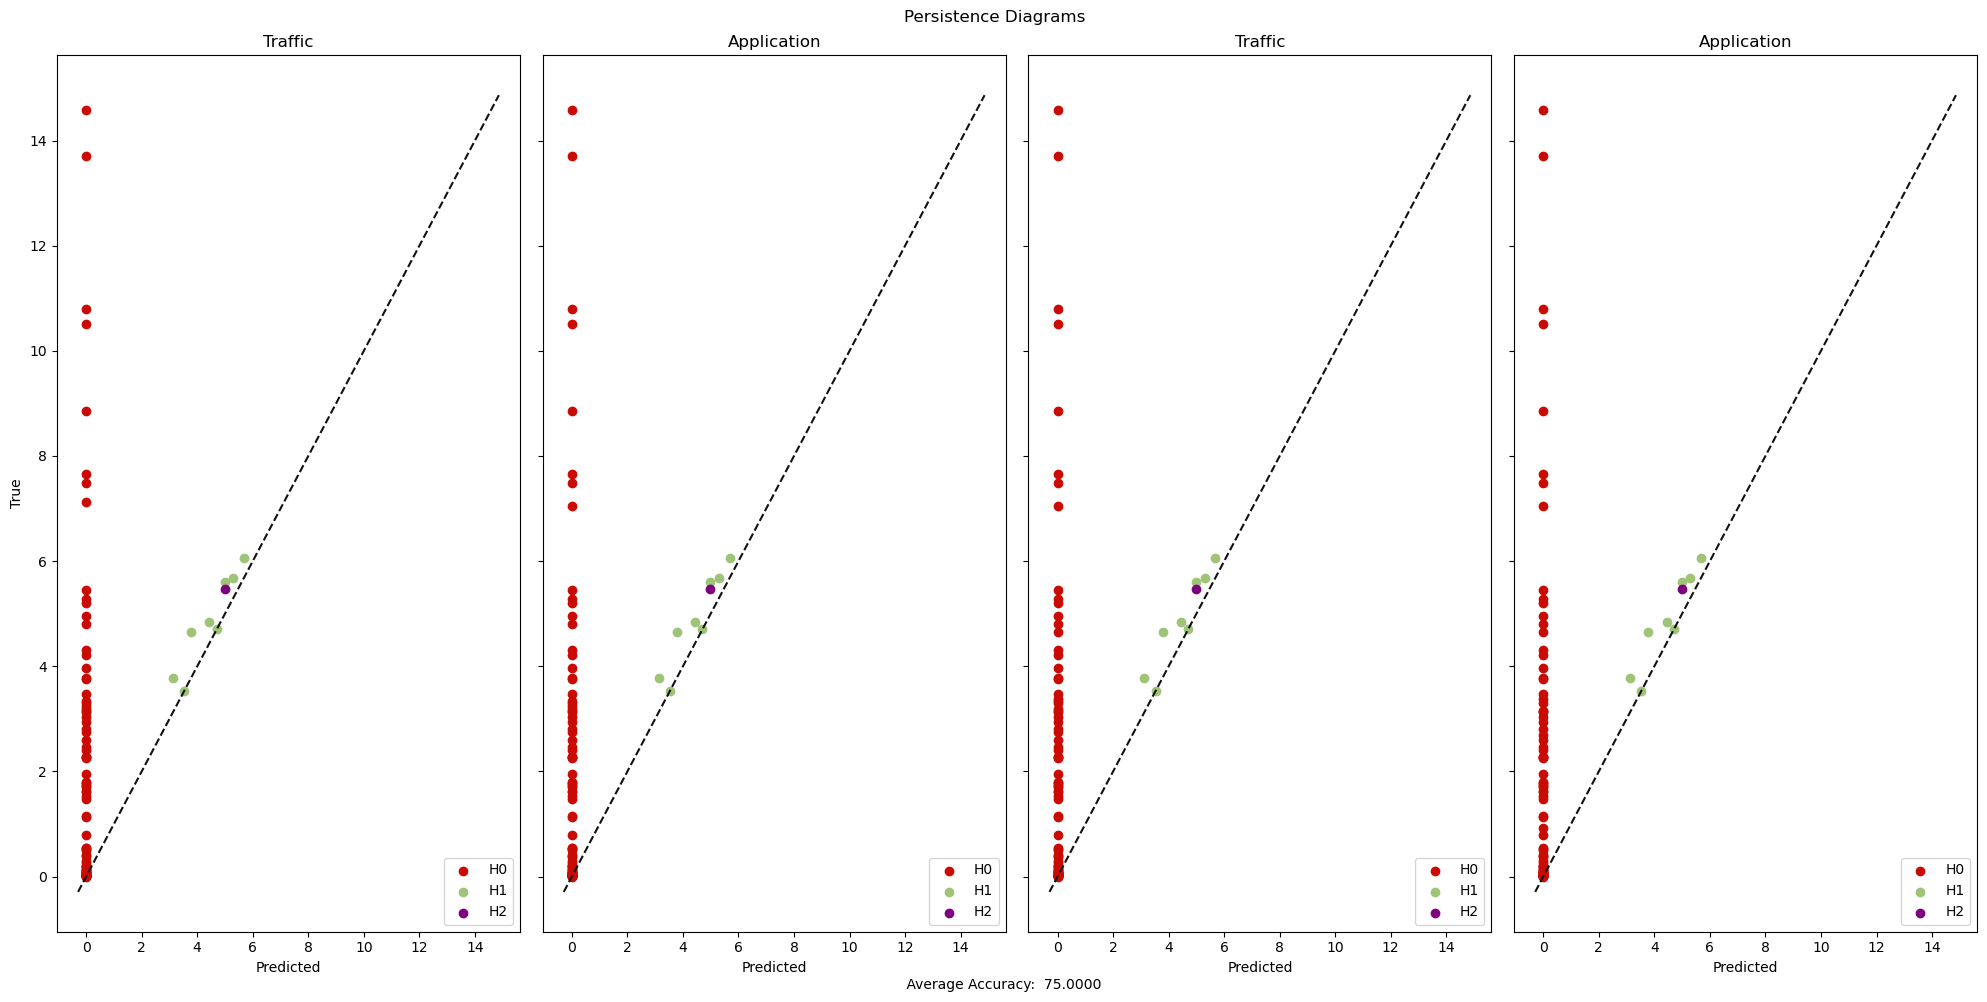

In [124]:
visualize_side_by_side(list(persistence[1:5]), {'accuracy': [0.9, 0.8, 0.7, 0.6]}, title='Persistence Diagrams', model_descriptions=['Traffic', 'Application', 'Traffic', 'Application'], plotting_function=plot_persistence, shape=(1,4))

<AxesSubplot:xlabel='Birth', ylabel='Death'>

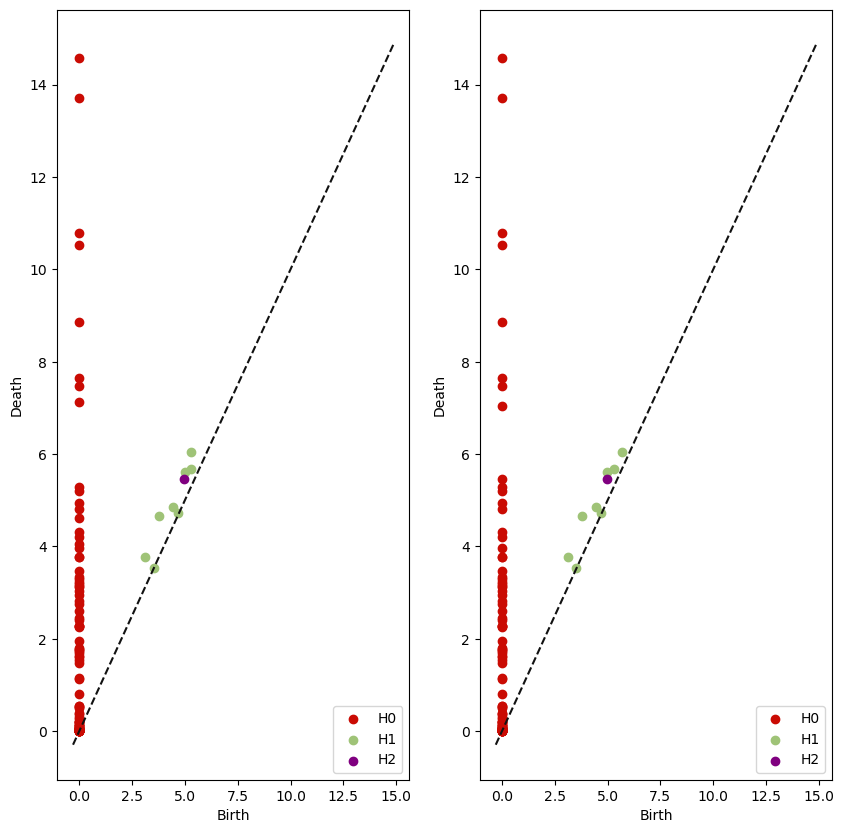

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
plot_persistence(persistence[0], ax=ax[0])
plot_persistence(persistence[2], ax=ax[1])

In [122]:

if ax == None:

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[min_val_display, max_val_display]
    y=[min_val_display, max_val_display],
    mode="lines",
    line={"dash": "dash", "width": 1, "color": "black"},
    showlegend=False,
    hoverinfo="none"
    ))

for dim in homology_dimensions:
    name = f"H{int(dim)}" if dim != np.inf else "Any homology dimension"
    subdiagram = diagram[diagram[:, 2] == dim]
    unique, inverse, counts = np.unique(
        subdiagram, axis=0, return_inverse=True, return_counts=True
        )
    hovertext = [
        f"{tuple(unique[unique_row_index][:2])}" +
        (
            f", multiplicity: {counts[unique_row_index]}"
            if counts[unique_row_index] > 1 else ""
        )
        for unique_row_index in inverse
        ]
    y = subdiagram[:, 1]
    if has_posinfinite_death:
        y[np.isposinf(y)] = posinfinity_val
    fig.add_trace(gobj.Scatter(
        x=subdiagram[:, 0], y=y, mode="markers",
        hoverinfo="text", hovertext=hovertext, name=name
    ))

fig.update_layout(
    width=500,
    height=500,
    xaxis1={
        "title": "Birth",
        "side": "bottom",
        "type": "linear",
        "range": [min_val_display, max_val_display],
        "autorange": False,
        "ticks": "outside",
        "showline": True,
        "zeroline": True,
        "linewidth": 1,
        "linecolor": "black",
        "mirror": False,
        "showexponent": "all",
        "exponentformat": "e"
        },
    yaxis1={
        "title": "Death",
        "side": "left",
        "type": "linear",
        "range": [min_val_display, max_val_display],
        "autorange": False, "scaleanchor": "x", "scaleratio": 1,
        "ticks": "outside",
        "showline": True,
        "zeroline": True,
        "linewidth": 1,
        "linecolor": "black",
        "mirror": False,
        "showexponent": "all",
        "exponentformat": "e"
        },
    plot_bgcolor="white"
    )

# Add a horizontal dashed line for points with infinite death
if has_posinfinite_death:
    fig.add_trace(gobj.Scatter(
        x=[min_val_display, max_val_display],
        y=[posinfinity_val, posinfinity_val],
        mode="lines",
        line={"dash": "dash", "width": 0.5, "color": "black"},
        showlegend=True,
        name=u"\u221E",
        hoverinfo="none"
    ))

# Update traces and layout according to user input
if plotly_params:
    fig.update_traces(plotly_params.get("traces", None))
    fig.update_layout(plotly_params.get("layout", None))



IndentationError: expected an indented block (<ipython-input-122-075ed030b40a>, line 3)

Text(0, 0.5, 'Death')

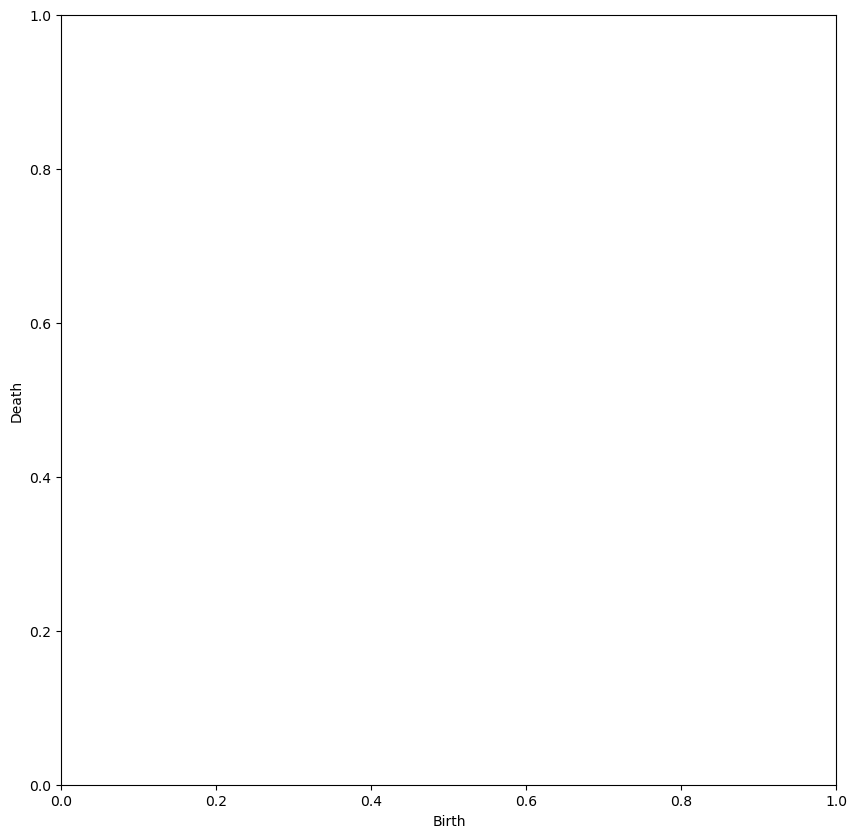

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlabel('Birth')
ax.set_ylabel('Death')
ax.scatter()

In [59]:
pip install persim

  Using cached persim-0.3.1-py3-none-any.whl (47 kB)
  Using cached hopcroftkarp-1.2.5.tar.gz (16 kB)
  Using cached Deprecated-1.2.13-py2.py3-none-any.whl (9.6 kB)
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18091 sha256=b03fd529e47af7169d32e7387ff395d9f2eddaee0b0bab31f21807c81ff8b23d
  Stored in directory: c:\users\nitro\appdata\local\pip\cache\wheels\d2\9f\a8\67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built hopcroftkarp
Note: you may need to restart the kernel to use updated packages.


In [60]:
import persim

In [61]:
imger = persim.PersistenceImager()

In [ ]:
  pers_dgm = np.copy(pers_dgm)

if skew:
    pers_dgm[:, 1] = pers_dgm[:, 1] - pers_dgm[:, 0]
    ylabel = 'persistence'
else:
    ylabel = 'death'

# setup plot range
plot_buff_frac = 0.05
bmin = np.min((np.min(pers_dgm[:, 0]), np.min(self._bpnts)))
bmax = np.max((np.max(pers_dgm[:, 0]), np.max(self._bpnts)))
b_plot_buff = (bmax - bmin) * plot_buff_frac
bmin -= b_plot_buff
bmax += b_plot_buff

pmin = np.min((np.min(pers_dgm[:, 1]), np.min(self._ppnts)))
pmax = np.max((np.max(pers_dgm[:, 1]), np.max(self._ppnts)))
p_plot_buff = (pmax - pmin) * plot_buff_frac
pmin -= p_plot_buff
pmax += p_plot_buff

ax = ax or plt.gca()
ax.set_xlim(bmin, bmax)
ax.set_ylim(pmin, pmax)

# compute reasonable line width for pixel overlay (initially 1/50th of the width of a pixel)
linewidth = (1/50 * self.pixel_size) * 72 * plt.gcf().bbox_inches.width * ax.get_position().width / \
            np.min((bmax - bmin, pmax - pmin))

# plot the persistence image grid
if skew:
    hlines = np.column_stack(np.broadcast_arrays(self._bpnts[0], self._ppnts, self._bpnts[-1], self._ppnts))
    vlines = np.column_stack(np.broadcast_arrays(self._bpnts, self._ppnts[0], self._bpnts, self._ppnts[-1]))
    lines = np.concatenate([hlines, vlines]).reshape(-1, 2, 2)
    line_collection = LineCollection(lines, color='black', linewidths=linewidth)
    ax.add_collection(line_collection)       

# plot persistence diagram
ax.scatter(pers_dgm[:, 0], pers_dgm[:, 1])

# plot diagonal if necessary
if not skew:
    min_diag = np.min((np.min(ax.get_xlim()), np.min(ax.get_ylim())))
    max_diag = np.min((np.max(ax.get_xlim()), np.max(ax.get_ylim())))
    ax.plot([min_diag, max_diag], [min_diag, max_diag])

# fix and label axes
ax.set_aspect('equal')
ax.set_xlabel('birth')
ax.set_ylabel(ylabel)


In [37]:
print(f'Last Execution: {datetime.datetime.now()}')
assert False, 'Nothing after this point is included in the study'

Last Execution: 2022-05-13 18:33:05.741780


AssertionError: Nothing after this point is included in the study